In [1]:
%matplotlib inline

In [2]:
from io import StringIO
import csv
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
def create_dataframe(csv_string, col_names):
    return pd.read_csv(StringIO(csv_string), sep=",(?![^{]*\})", quoting=csv.QUOTE_ALL,
                       names=col_names, header=None)


def filter_logs(csv_file, keyword):
    with open(csv_file) as f:
        return ''.join([line for line in f if keyword in line]).strip()


def get_new_tree_info(log_file):
    logs = filter_logs(log_file, "new-tree-info")

    # Wrap tree in quotation marks
    parsed = []
    for line in logs.split('\n'):
        line = line.split(',', 7)
        line[-1] = '"{}"'.format(line[-1])
        parsed.append(', '.join(line))
    logs = '\n'.join(parsed)

    cols = ["level", "time", "module", "log-type",
            "tree-id", "num-scanned", "gamma", "tree"]
    return create_dataframe(logs, cols)


def get_performance(log_file):
    logs0 = filter_logs(log_file, "global_speed")
    logs1 = filter_logs(log_file, "learner_spped")
    # logs = filter_logs(log_file, "boosting_speed")

    parsed = []
    for line0, line1 in zip(logs0.split('\n'), logs1.split('\n')):
        line = line0 + ', ' + ', '.join(line1.rsplit(',', 3)[-3:])
        parsed.append(line)
    logs = '\n'.join(parsed)

    cols = ["level", "time", "module", "log-type",
            "overall-duration", "overall-count", "overall-speed",
            "learner-duration", "learner-count", "learner-speed"]
    return create_dataframe(logs, cols)


def get_true_z(log_file):
    logs = filter_logs(log_file, "validate-only")

    cols = ["level", "time", "module", "log-type",
            "tree-id", "true-z", "auprc"]
    return create_dataframe(logs, cols)

In [145]:
trees = []
speed = []
true_z = []

range_size = [564, 464, 364, 264, 164, 64, 44, 24]
for i in range(8):
    _trees = get_new_tree_info("../logs-analysis/local/run%d/run-%d.log" % (i, i))
    _trees["estimated-z"] = np.exp(-(_trees["gamma"]**2).cumsum())
    _trees["range"] = range_size[i]
    trees.append(_trees)
    _speed = get_performance("../logs-analysis/local/run%d/run-%d.log" % (i, i))
    _speed["range"] = range_size[i]
    speed.append(_speed)
    _true_z = get_true_z("../logs-analysis/local/run%d/validate.log" % i)
    _true_z["range"] = range_size[i]
    true_z.append(_true_z)

trees = pd.concat(trees)
speed = pd.concat(speed)
true_z = pd.concat(true_z)

trees = trees.drop(columns=["level", "module", "log-type", "tree"])
true_z = true_z.drop(columns=["level", "module", "log-type", "time"])
speed = speed.drop(columns=["level", "module", "log-type"])

In [133]:
tree_info = trees.merge(true_z, on=["tree-id", "range"], how="outer")
tree_info.head()

,time,tree-id,num-scanned,gamma,estimated-z,range,true-z,auprc
0,497068.810703,1,10000,0.496800,0.781289,564,0.111952,0.006288
1,497264.414499,2,345000,0.164025,0.760549,564,NaN,NaN
2,497288.188954,3,44000,0.119574,0.749752,564,NaN,NaN
3,497297.189503,4,150000,0.107617,0.741119,564,NaN,NaN
4,497297.464755,5,35000,0.107617,0.732586,564,NaN,NaN


In [134]:
tree_info_by_id = tree_info.set_index("tree-id")
tree_info_by_time = tree_info.set_index("time")

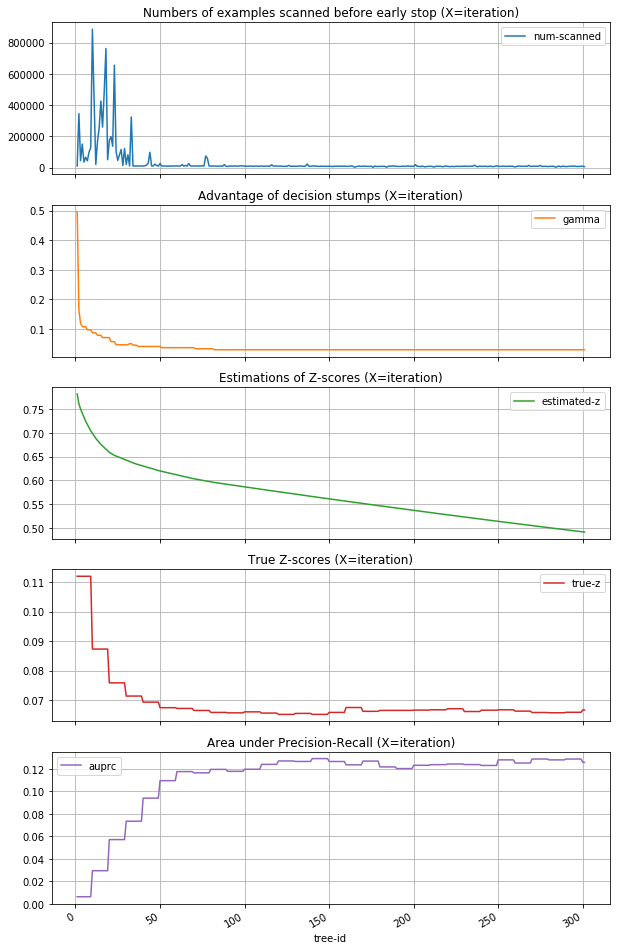

In [166]:
tree_info_by_id[tree_info_by_id["range"] == 564] \
    .drop(columns=["range", "time"]).fillna(method="pad").plot(
        subplots=True, figsize=(10, 18), grid=True,
        title=[
            "Numbers of examples scanned before early stop (X=iteration)",
            "Advantage of decision stumps (X=iteration)",
            "Estimations of Z-scores (X=iteration)",
            "True Z-scores (X=iteration)",
            "Area under Precision-Recall (X=iteration)"
        ]
    );

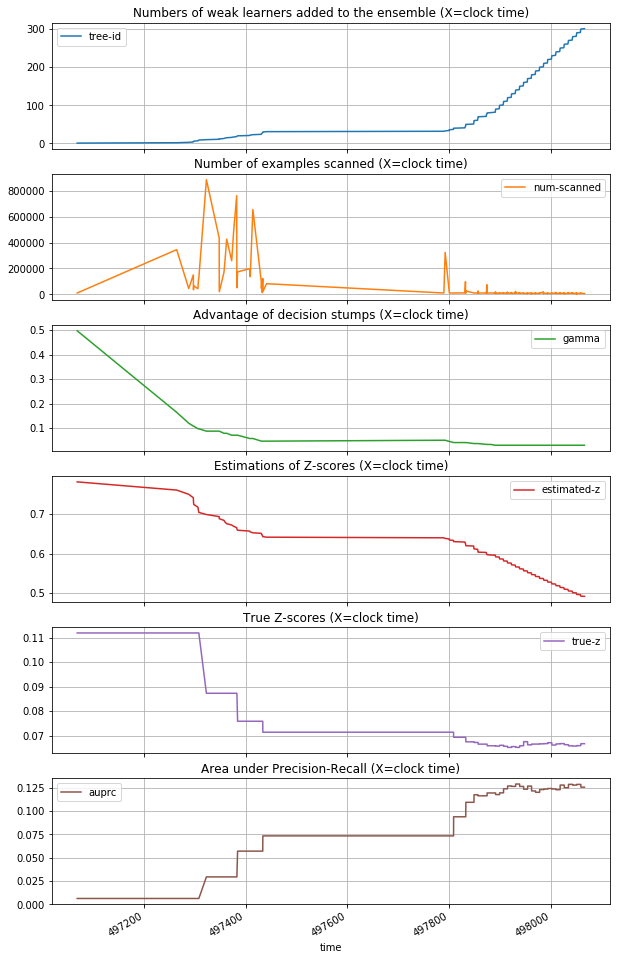

In [170]:
tree_info_by_time[tree_info_by_time["range"] == 564] \
    .drop(columns=["range"]).fillna(method="pad").plot(
        subplots=True, figsize=(10, 18), grid=True,
        title=[
            "Numbers of weak learners added to the ensemble (X=clock time)",
            "Number of examples scanned (X=clock time)",
            "Advantage of decision stumps (X=clock time)",
            "Estimations of Z-scores (X=clock time)",
            "True Z-scores (X=clock time)",
            "Area under Precision-Recall (X=clock time)"
        ]
    );

In [146]:
speed = speed.set_index("time")
speed_dropped = speed[speed["range"] == 564].drop(
    columns=["range", "overall-speed", "learner-speed"]
)
speed_dropped.head()

,overall-duration,overall-count,learner-duration,learner-count
time,,,,
497240.656864,10.001000,1286000,7.732000,1286000
497250.658245,20.002000,2569938,15.472001,2569938
497260.664418,30.009000,3861938,23.225000,3861938
497270.664736,40.009003,5144876,30.923002,5144876
497280.671261,50.015003,6426876,38.616000,6426876


# Cost of resampling

In the following plot, we can see two measures of the number of examples scanned as a function of the clock time:

1. `overall-count`: the total number of examples read from disk, which is the sum of the numbers of
examples scanned for the purpose of resampling and for the purpose of learning the weak rule,
2. `learner-count`: the number of examples read for the purpose of finding the new weak rule.

The difference bewteen `overall-count` and `learner-count` is the number of examples scanned for
re-sampling. In this version of the program we don't have the stratified sampling implemented,
so it takes a full scan of the entire training data set to generate a new sample.

As it shows in the plot, re-sampling consumes examples at a faster rate than finding a new weak rule,
but still takes a significant amount of time.

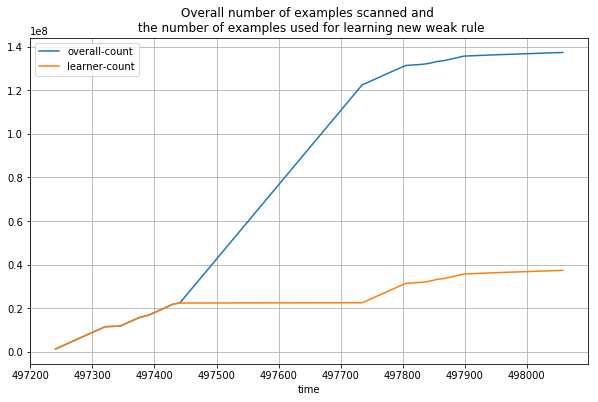

In [172]:
speed_dropped.drop(columns=["overall-duration", "learner-duration"]).plot(
    figsize=(10, 6), grid=True,
    title = "Overall number of examples scanned and \n the number of examples "
            "used for finding new weak rule"
);

In [173]:
"""
speed_dropped.drop(columns=["overall-count", "learner-count"]).plot(
    figsize=(10, 6), grid=True
);
""";